<a href="https://colab.research.google.com/github/pharringtonp19/rfp/blob/main/notebooks/local_weighted_linear_regression_no_avg_effect_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from jax import random, vmap
import jax
import jax.numpy as jnp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
min_obs, max_obs, n_cohorts, eps, n_epochs = 10, 50, 6, 1.5, 1000
key_num = 18
key = jax.random.PRNGKey(key_num)

In [3]:
def main_effect(x):
  return jnp.log(x**2 + 1.0 + jnp.sin(x*3)) + 1.5

def gen_functions(key, x, i):
  key, subkey = jax.random.split(key)
  weights = random.normal(subkey, shape=(4,))
  y = main_effect(x) #weights[0] + weights[1]*x + weights[2] * jnp.sin(x)
  y = y - jnp.mean(y) # Normalize within Cluster
  plt.scatter(x, y, label=i+1)
  return y 

def gen_samples(key, min_obs, max_obs, n_cohorts, eps):
  d = {}
  fig = plt.figure(dpi=300, tight_layout=True, figsize=(6.4, 4.8))
  for i in range(n_cohorts):
    key, subkey = jax.random.split(key)
    n_obs = jax.random.choice(subkey, max_obs-min_obs ) + min_obs
    x_mean = random.normal(key, shape=(1,))
    x = jnp.linspace(x_mean - eps, x_mean + eps, n_obs) 
    y = gen_functions(key, x, i)
    d[i] = jnp.hstack((x, y))
  plt.legend(title=r'$E[Y|C=i]$', ncol=2, fontsize='xx-small')
  plt.title(r'$Y$', loc='left')
  plt.xlabel(r'$X$')
  fig.savefig('motivating_cefs.pdf', format='pdf')
  plt.show()
  return d

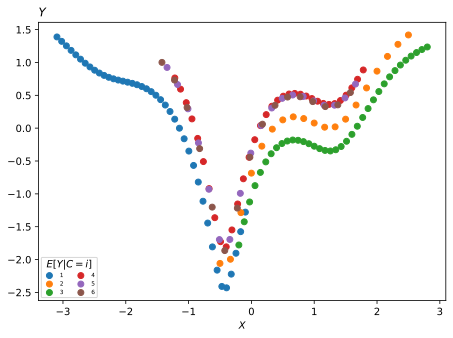

In [4]:
data = gen_samples(key, min_obs, max_obs, n_cohorts, eps)


In [5]:
data_matrix = jnp.vstack((i for i in data.values()))
data_matrix = jnp.hstack((jnp.ones((data_matrix.shape[0], 1)), data_matrix))

In [6]:
def weight(xi, x, tau):
  return jnp.exp( - (xi -x)**2/2*tau**2)

def weight_matrix(x, tau):
  return vmap(weight, in_axes=(0, None, None))(data_matrix[:,1], x, tau)

def params(X, W, Y):
  return jnp.matmul(jnp.linalg.inv(jnp.matmul(X.T, jnp.matmul(jnp.diag(W.reshape(-1,)),X))),jnp.matmul(X.T, jnp.matmul(jnp.diag(W.reshape(-1,)),Y)))

def predict(weights, inputs):
  return jnp.dot(weights, inputs)

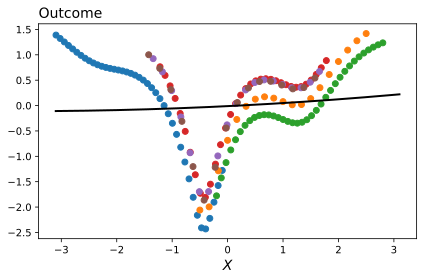

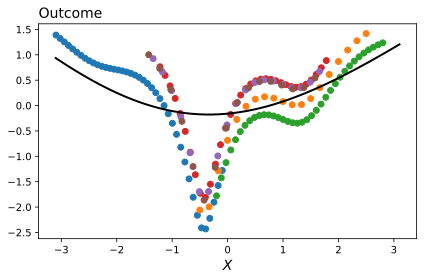

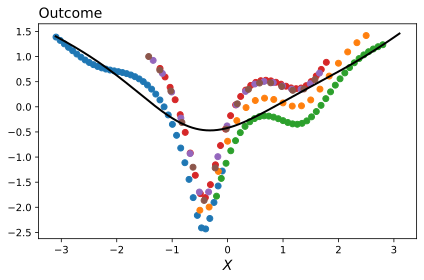

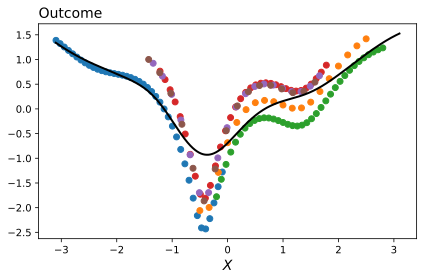

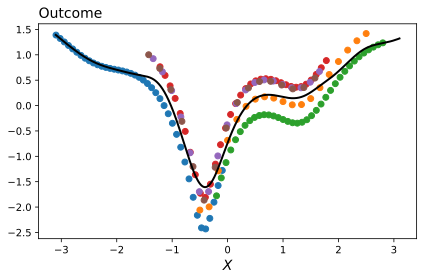

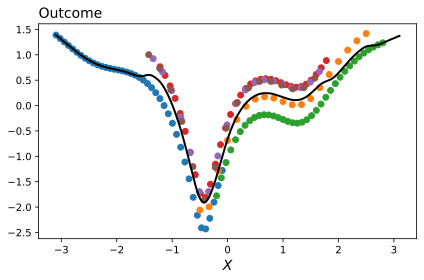

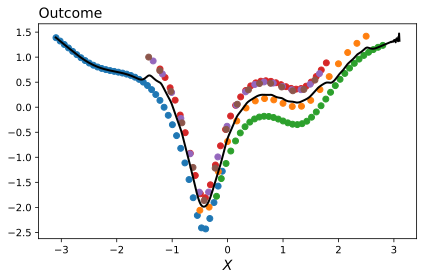

In [7]:
for bw in [0.1, 0.5, 1., 2., 5., 10., 15.]:
  inputs = jnp.linspace(-3.1,3.1,1000).reshape(-1,1)
  weights = vmap(weight_matrix, in_axes=(0, None))(inputs, bw)
  local_linear_thetas = vmap(params, in_axes=(None, 0, None))(data_matrix[:,:2], weights, data_matrix[:, -1].reshape(-1,1))
  intercept_inputs = jnp.hstack((jnp.ones_like(inputs), inputs))
  yhat = vmap(predict, in_axes=(0,0))(intercept_inputs, local_linear_thetas)
  fig = plt.figure(dpi=300, tight_layout=True)
  plt.plot(inputs, yhat, color='black', linewidth=2)
  for i in range(len(data)):
    plt.scatter(data[i][:,0], data[i][:, 1])
  plt.title('Outcome', loc='left', size=14)
  plt.xlabel(r'$X$', size=14)
  fig.savefig(f'local_linear_no_const_{bw}_{key_num}_LM.pdf', format='pdf')
  fig.savefig(f'local_linear_no_const_{bw}_{key_num}_LM.png', format='png')
  plt.show()